### 8.1.1. 统计工具
处理序列数据需要统计工具和新的深度神经网络架构。 为了简单起见，我们以 图8.1.1所示的股票价格（富时100指数）为例。其中，用 $x_t$ 表示价格，即在时间$t$的价格。于是通过以下途径预测未来的价格：
$$x_t \sim P(x_t \mid x_{t-1}, \ldots, x_1).$$

#### 8.1.1.1. 自回归模型
第一种策略假设在现实情况下，相当长的序列 $x_{t-1}, \ldots, x_1$ 可能是不必要的，因此我们只需要满足某个长度为 $\tau$ 的时间跨度，即使用观测序列 $x_{t-1}, \ldots, x_{t-\tau}$。当下获得的最直接的好处是参数的数量总是不变的，至少在 $t > \tau$ 时如此，这使我们能够训练一个上面提及的深度网络。这种模型被称为自回归模型（autoregressive models），因为它们是对自己执行回归。

第二种策略，如图 8.1.2 所示，是保留一些对过去观测的总结 $h_{t}$，并且同时更新预测 $\hat{x}_t$ 和总结 $h_t$。这就产生了基于 $\hat{x}_t = P(x_t \mid h_{t})$ 估计 $x_t$，以及公式 $h_t = g(h_{t-1}, x_{t-1})$ 更新的模型。由于 $h_t$ 从未被观测到，这类模型也被称为隐变量自回归模型（latent autoregressive models）。

这样的假设是合理的，因为新的动力学一定受新的数据影响， 而我们不可能用目前所掌握的数据来预测新的动力学。 统计学家称不变的动力学为静止的（stationary）。 因此，整个序列的估计值都将通过以下的方式获得：
$$
P(x_1, \ldots, x_T) = \prod_{t=1}^T P(x_t \mid x_{t-1}, \ldots, x_1)
$$

#### 8.1.1.2. 马尔可夫模型
回想一下，在自回归模型的近似法中， 我们使用 $x_{t-1}, \dots , x_{t-\tau}$ 而不是 $x_{t-1}, \dots, x_{t-1}$来估计 $x_t$。 只要这种是近似精确的，我们就说序列满足马尔可夫条件（Markov condition）。
一阶Markov Model：
$$
P(x_1, \ldots, x_T) = \prod_{t=1}^T P(x_t \mid x_{t-1}) \text{ 当 } P(x_1 \mid x_0) = P(x_1).
$$

#### 8.1.1.3. 因果关系
很明显，未来的事件不能影响过去。 因此，如果我们改变 $x_t$ ，可能会影响未来发生的事情 $x_{t+1}$ ，但不能反过来。 也就是说，如果我们改变 $x_t$，基于过去事件得到的分布不会改变。 因此，解释 $P(x_{t+1} \mid x_t)$ 应该比解释 $P(x_t \mid x_{t+1})$ 更容易。 

### 8.1.2. 训练

c:\Users\yy200\miniconda3\envs\d2l\lib\site-packages\torchvision\io\image.py:14: UserWarning: Failed to load image Python extension: '[WinError 127] 找不到指定的程序。'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


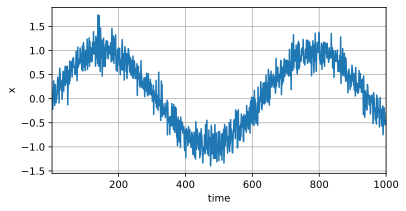

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [2]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [3]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

In [14]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.079819
epoch 2, loss: 0.060352
epoch 3, loss: 0.057581
epoch 4, loss: 0.056480
epoch 5, loss: 0.053779


### 8.1.3. 预测

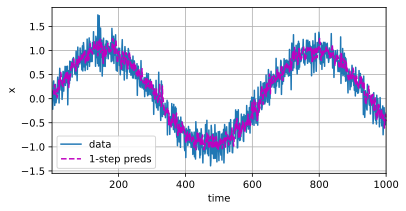

In [15]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

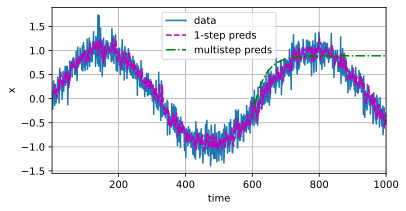

In [16]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

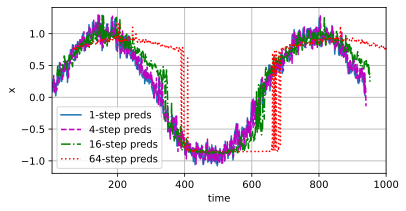

In [17]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))

### 8.1.5. 练习解答

#### 1. 改进本节实验中的模型
1.1 是否包含了过去4个以上的观测结果？真实值需要是多少？
- 是的，模型中包含了过去4个观测结果（由变量`tau=4`定义）。真实值需要根据具体的时间序列特性确定，但通常需要更多的观测结果以捕获更复杂的模式。

1.2 如果没有噪音，需要多少个过去的观测结果？提示：把$\sin$和$\cos$写成微分方程。
- 如果没有噪音，$\sin$和$\cos$可以通过二阶微分方程描述：
    $$
    \frac{d^2x}{dt^2} + x = 0
    $$
    因此，只需要两个过去的观测结果即可确定当前状态。

1.3 可以在保持特征数量不变的情况下合并旧的观测结果吗？这能提高正确度吗？为什么？
- 可以通过特征提取或降维技术（如PCA）合并旧的观测结果。这可能提高正确度，因为它减少了冗余信息并突出关键特征，但也可能丢失部分信息，具体效果需视数据而定。

1.4 改变神经网络架构并评估其性能。
- 可以尝试增加隐藏层、改变激活函数或使用循环神经网络（如LSTM、GRU）来改进模型性能。评估性能时可以使用验证集上的损失或其他指标。

#### 2. 一位投资者想要找到一种好的证券来购买。他查看过去的回报，以决定哪一种可能是表现良好的。这一策略可能会出什么问题？
- 这一策略可能会忽略市场的动态变化和未来的不确定性。过去的表现并不能完全预测未来的回报，可能导致过拟合历史数据。此外，市场可能存在非线性关系或外部因素的影响。

#### 3. 时间是向前推进的因果模型在多大程度上适用于文本呢？
- 因果模型在文本生成中非常适用，例如语言模型（如GPT）通过前面的单词预测后续单词。然而，文本中的上下文可能需要更长的历史信息，因此需要更复杂的模型（如Transformer）来捕获长距离依赖。

#### 4. 举例说明什么时候可能需要隐变量自回归模型来捕捉数据的动力学模型。
- 隐变量自回归模型适用于以下场景：
    - 金融市场：价格受未观测的市场情绪或政策变化影响。
    - 气象预测：天气变化受未观测的复杂大气动力学影响。
    - 医疗数据：病人健康状态受未观测的生理或心理因素影响。